# Analysis Notebook

#### Initialisation Cells

In [1]:
import os
import sys
import re
import ast
import json
import matplotlib.pyplot as plt

sys.path.append("../src")

from config import Parser
from data import DatasetManager
from models import LogisticRegressionClf, RandomForestClf, XGBoostClf, MetaPath2VecClf, GNNClf

LEARNERS = {
    "logistic-regression": LogisticRegressionClf,
    "random-forest": RandomForestClf,
    "xgboost": XGBoostClf,
    "metapath2vec": MetaPath2VecClf,
    "gnn": GNNClf
}


def load_experiment(path):
    with open(os.path.join(path, "report.md"), "r") as report_file:
        reading = True
        while reading:
            line = report_file.readline()
            reading = False if re.compile(r"--END--").search(line) else True
            
            match = re.compile(r"## Config").search(line)
            if match:
                config = ""
                line = report_file.readline()
                end = False
                while not end:
                    config += line
                    line = report_file.readline()
                    end = True if re.compile(r"## Data").search(line) else False
                
    config = json.loads(config)
    
    parser = Parser(config)
    exp_args, data_args, model_args, train_args = parser.parse()
    
    data = DatasetManager(data_args["type"], data_args["args"])
    data.data.remove_data()

    data_args["args"]["customer_transforms"] = data.data.customer_transforms
    data_args["args"]["product_transforms"] = data.data.product_transforms

    test_data = DatasetManager(data_args["type"], data_args["args"], test=True)
    test_data.data.remove_data()
    
    model = LEARNERS[model_args["type"]](data, test_data, val_dataset=False, loss=model_args["loss"], model_args=model_args["args"])
    
    model.load(path)

    return test_data, model

def get_GNN_and_testdata(path):
    test_data_gnn, model_gnn = load_experiment(path)
    return model_gnn, test_data_gnn

def get_edge_results(data, preds, targets):
    import torch
    import pandas as pd
    import numpy as np

    customer_node_lookup = pd.DataFrame(torch.stack([data.data[0]["customer"].node_index, data.data[0]["customer"].originalID], 
                    axis=1).numpy(), columns=["customer_id", "hash(customerId)"])

    variant_node_lookup = pd.DataFrame(torch.stack([data.data[0]["variant"].node_index, data.data[0]["variant"].originalID], 
                    axis=1).numpy(), columns=["variant_id", "variantID"])

    edge_results = pd.DataFrame(data.data[0]["customer", "purchases", "variant"].edge_index.T.numpy(), 
                                columns=["customer_id", "variant_id"])
    edge_results["prediction"] = np.round(preds.detach().numpy()[:,1]).astype(np.int32)
    edge_results["target"] = targets
    edge_results = pd.merge(edge_results, customer_node_lookup, on="customer_id", how="inner")
    edge_results = pd.merge(edge_results, variant_node_lookup, on="variant_id", how="inner")
    return edge_results

### Setting up the analysis

Here we load in a particular experiment for error analysis.

In [2]:
data, model = load_experiment("../results/test/07042022_124222")
preds = model.model.forward(data.data[0].x_dict, data.data[0].edge_index_dict,
                            data.data[0]["customer", "purchases", "variant"].edge_index)
targets = data.data[0]["customer", "purchases", "variant"].edge_label

edge_results = get_edge_results(data, preds, targets)

Processing...
Done!
Processing...
Done!


### Confusion Matrix Analysis

Using the models predictions we can reconstruct the elements of the confusion matrix.

In [3]:
tp = edge_results[(edge_results.prediction == 1) & (edge_results.target == 1)]
fp = edge_results[(edge_results.prediction == 1) & (edge_results.target == 0)]
tn = edge_results[(edge_results.prediction == 0) & (edge_results.target == 0)]
fn = edge_results[(edge_results.prediction == 0) & (edge_results.target == 1)]

print(f"""TP: {100*len(tp)/len(edge_results):.2f}%, \
        \nFP: {100*len(fp)/len(edge_results):.2f}%, \
        \nTN: {100*len(tn)/len(edge_results):.2f}%, \
        \nFN: {100*len(fn)/len(edge_results):.2f}%""")

TP: 44.67%,         
FP: 24.41%,         
TN: 23.88%,         
FN: 7.04%


#### Single Market Confusion Matrices

First we need to find all the raw features for the predictions by merging some datasets.

In [4]:
import pandas as pd

cust_idx = pd.Series(data.data[0]["customer"].originalID.numpy(), name="hash(customerId)")
cust_x = pd.read_csv("../raw/gnn_data/customer_nodes_testing.csv")
customers = pd.merge(cust_x, cust_idx, on="hash(customerId)", how="inner")

var_idx = pd.Series(data.data[0]["variant"].originalID.numpy(), name="variantID")
var_x = pd.read_csv("../raw/gnn_data/product_nodes_testing.csv")
variants = pd.merge(var_x, var_idx, on="variantID", how="inner")

In [5]:
tp_cust = pd.merge(tp["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
tp_var = pd.merge(tp["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

fn_cust = pd.merge(fn["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
fn_var = pd.merge(fn["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

tn_cust = pd.merge(tn["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
tn_var = pd.merge(tn["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

fp_cust = pd.merge(fp["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
fp_var = pd.merge(fp["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)


##### Country Markets

Now we have the customer and product information which was involved in a TP, TN, FP and FN prediction.

In [22]:
for country in customers.shippingCountry.unique():
    tp_temp = tp_cust[tp_cust["shippingCountry"] == country]
    fn_temp = fn_cust[fn_cust["shippingCountry"] == country]
    tn_temp = tn_cust[tp_cust["shippingCountry"] == country]
    fp_temp = fp_cust[tp_cust["shippingCountry"] == country]

    country_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nCountry: {country}
        \nTP: {100*len(tp_temp)/country_total:.2f}%, \
        \nFP: {100*len(fn_temp)/country_total:.2f}%, \
        \nTN: {100*len(tn_temp)/country_total:.2f}%, \
        \nFN: {100*len(fp_temp)/country_total:.2f}%\n""")

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



Country: UK
        
TP: 40.33%,         
FP: 11.16%,         
TN: 23.41%,         
FN: 25.11%


Country: Australia
        
TP: 45.22%,         
FP: 14.30%,         
TN: 19.20%,         
FN: 21.28%


Country: Austria
        
TP: 40.08%,         
FP: 5.47%,         
TN: 26.49%,         
FN: 27.95%


Country: Netherlands
        
TP: 42.15%,         
FP: 5.95%,         
TN: 25.01%,         
FN: 26.89%


Country: Sweden
        
TP: 41.45%,         
FP: 6.52%,         
TN: 25.11%,         
FN: 26.91%


Country: Germany
        
TP: 40.44%,         
FP: 4.37%,         
TN: 26.89%,         
FN: 28.31%


Country: France
        
TP: 40.58%,         
FP: 11.54%,         
TN: 23.11%,         
FN: 24.77%


Country: United States
        
TP: 45.61%,         
FP: 11.81%,         
TN: 20.30%,         
FN: 22.29%


Country: Denmark
        
TP: 40.76%,         
FP: 9.63%,         
TN: 23.97%,         
FN: 25.64%



##### Brand Markets

In [23]:
for brand in variants.brandDesc.unique():
    tp_temp = tp_var[tp_var["brandDesc"] == brand]
    fn_temp = fn_var[fn_var["brandDesc"] == brand]
    tn_temp = tn_var[tp_var["brandDesc"] == brand]
    fp_temp = fp_var[tp_var["brandDesc"] == brand]

    brand_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nBrand: {brand}
        \nTP: {100*len(tp_temp)/brand_total:.2f}%, \
        \nFP: {100*len(fn_temp)/brand_total:.2f}%, \
        \nTN: {100*len(tn_temp)/brand_total:.2f}%, \
        \nFN: {100*len(fp_temp)/brand_total:.2f}%\n""")

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



Brand: other
        
TP: 46.13%,         
FP: 11.42%,         
TN: 19.42%,         
FN: 23.02%


Brand: ASOS DESIGN
        
TP: 39.26%,         
FP: 9.59%,         
TN: 23.66%,         
FN: 27.49%


Brand: Topshop
        
TP: 38.51%,         
FP: 8.66%,         
TN: 24.78%,         
FN: 28.05%


Brand: Nike
        
TP: 34.58%,         
FP: 18.43%,         
TN: 22.11%,         
FN: 24.89%


Brand: ASOS Curve
        
TP: 40.02%,         
FP: 14.23%,         
TN: 20.68%,         
FN: 25.07%


Brand: Pull&Bear
        
TP: 38.36%,         
FP: 7.40%,         
TN: 25.51%,         
FN: 28.73%


Brand: ASOS Petite
        
TP: 39.31%,         
FP: 6.92%,         
TN: 25.05%,         
FN: 28.73%


Brand: Collusion
        
TP: 38.01%,         
FP: 12.47%,         
TN: 22.90%,         
FN: 26.62%


Brand: Bershka
        
TP: 37.63%,         
FP: 6.10%,         
TN: 26.66%,         
FN: 29.61%


Brand: New Look
        
TP: 38.94%,         
FP: 8.68%,         
TN: 24.27%,         
FN: 28.

##### Product Type Markets

In [25]:
for prodType in variants.productType.unique():
    tp_temp = tp_var[tp_var["productType"] == prodType]
    fn_temp = fn_var[fn_var["productType"] == prodType]
    tn_temp = tn_var[tp_var["productType"] == prodType]
    fp_temp = fp_var[tp_var["productType"] == prodType]

    type_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nProductType: {prodType}
        \nTP: {100*len(tp_temp)/type_total:.2f}%, \
        \nFP: {100*len(fn_temp)/type_total:.2f}%, \
        \nTN: {100*len(tn_temp)/type_total:.2f}%, \
        \nFN: {100*len(fp_temp)/type_total:.2f}%\n""")

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



ProductType: Dresses
        
TP: 44.81%,         
FP: 4.99%,         
TN: 23.18%,         
FN: 27.02%


ProductType: T-shirts
        
TP: 39.25%,         
FP: 16.50%,         
TN: 20.44%,         
FN: 23.81%


ProductType: Jeans
        
TP: 42.37%,         
FP: 5.82%,         
TN: 24.08%,         
FN: 27.73%


ProductType: Shirts
        
TP: 42.27%,         
FP: 9.31%,         
TN: 22.22%,         
FN: 26.20%


ProductType: Jackets
        
TP: 42.35%,         
FP: 7.86%,         
TN: 22.93%,         
FN: 26.86%


ProductType: Trainers
        
TP: 41.18%,         
FP: 20.17%,         
TN: 17.52%,         
FN: 21.13%


ProductType: Jumpers
        
TP: 37.86%,         
FP: 12.25%,         
TN: 23.43%,         
FN: 26.45%


ProductType: Crop Tops
        
TP: 39.14%,         
FP: 9.80%,         
TN: 23.96%,         
FN: 27.10%


ProductType: Trousers
        
TP: 42.34%,         
FP: 6.30%,         
TN: 23.73%,         
FN: 27.64%


ProductType: Shorts
        
TP: 41.54%,         

##### Specific Feature Analysis

From here we can investigate a more in depth analysis of the individual features.

In [28]:
tp_cust["pred_type"] = "TP"
tp_var["pred_type"] = "TP"
fn_cust["pred_type"] = "FN"
fn_var["pred_type"] = "FN"
tn_cust["pred_type"] = "TN"
tn_var["pred_type"] = "TN"
fp_cust["pred_type"] = "FP"
fp_var["pred_type"] = "FP"

# Get all the positive return examples
tpfn_cust = pd.concat([tp_cust.sample(n=1000), fn_cust.sample(n=1000)]).reset_index(drop=True)
tpfn_var = pd.concat([tp_var.sample(n=1000), fn_var.sample(n=1000)]).reset_index(drop=True)

# Get all the negative return examples
tnfp_cust = pd.concat([tn_cust.sample(n=1000), fp_cust.sample(n=1000)]).reset_index(drop=True)
tnfp_var = pd.concat([tn_var.sample(n=1000), fp_var.sample(n=1000)]).reset_index(drop=True)


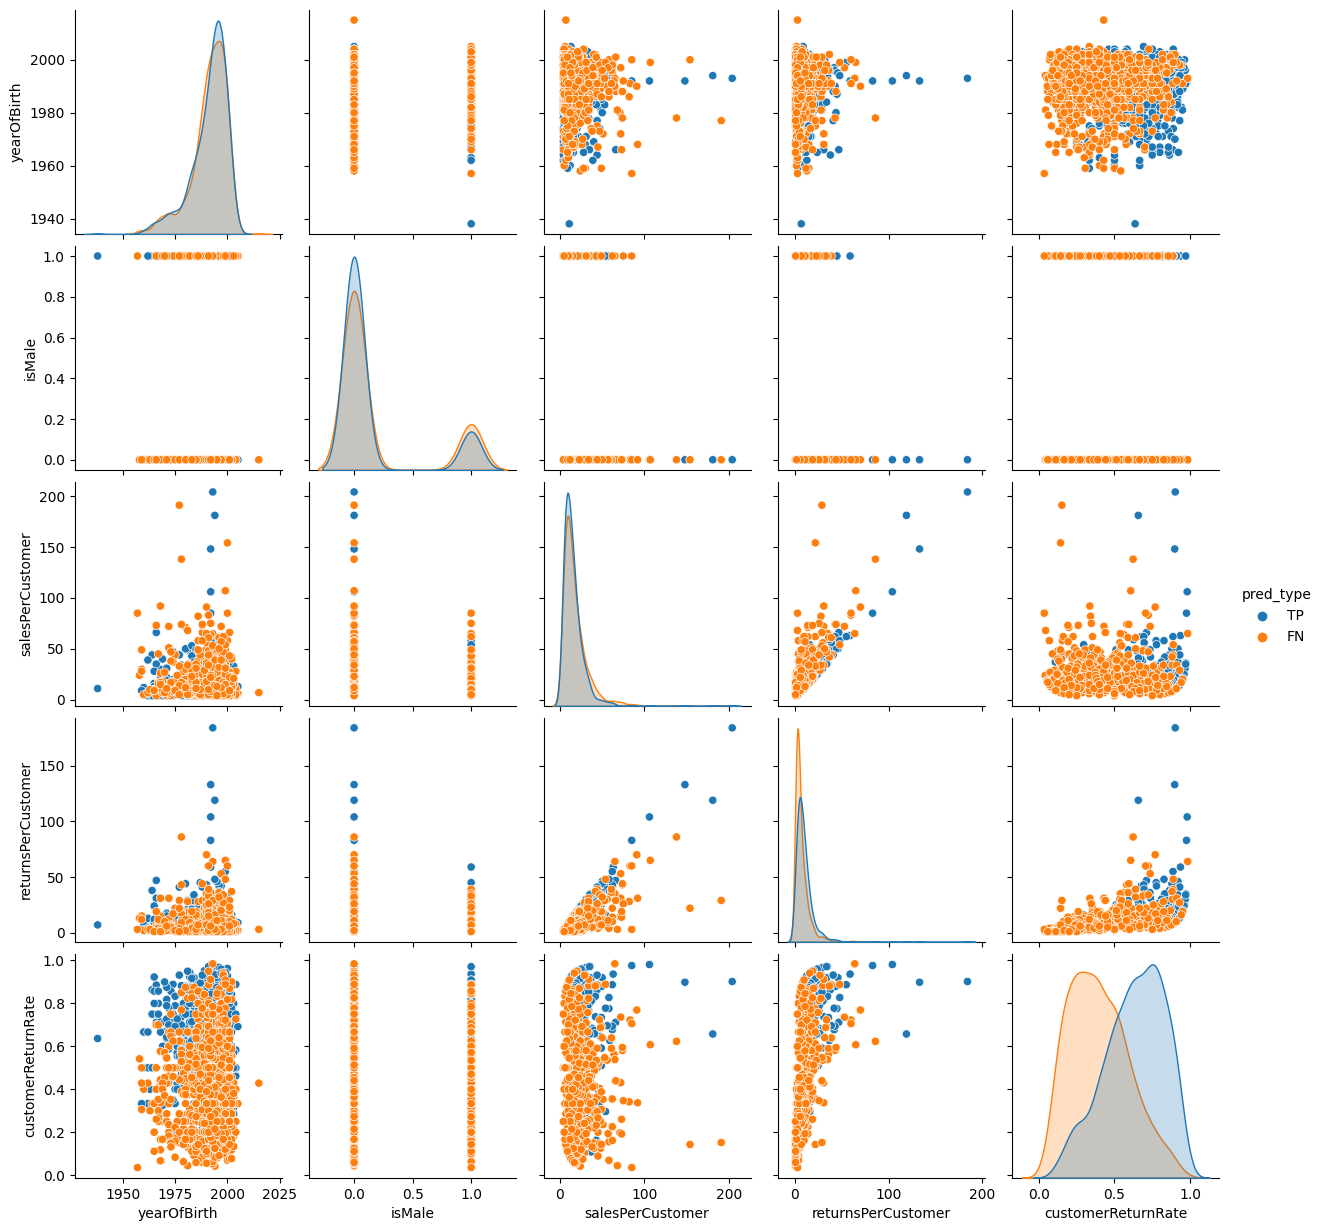

In [13]:
import seaborn as sns

sns.pairplot(data=tpfn_cust[["yearOfBirth", 
                               "isMale", 
                               "salesPerCustomer", 
                               "returnsPerCustomer", 
                               "customerReturnRate", 
                               "pred_type"]], hue="pred_type")

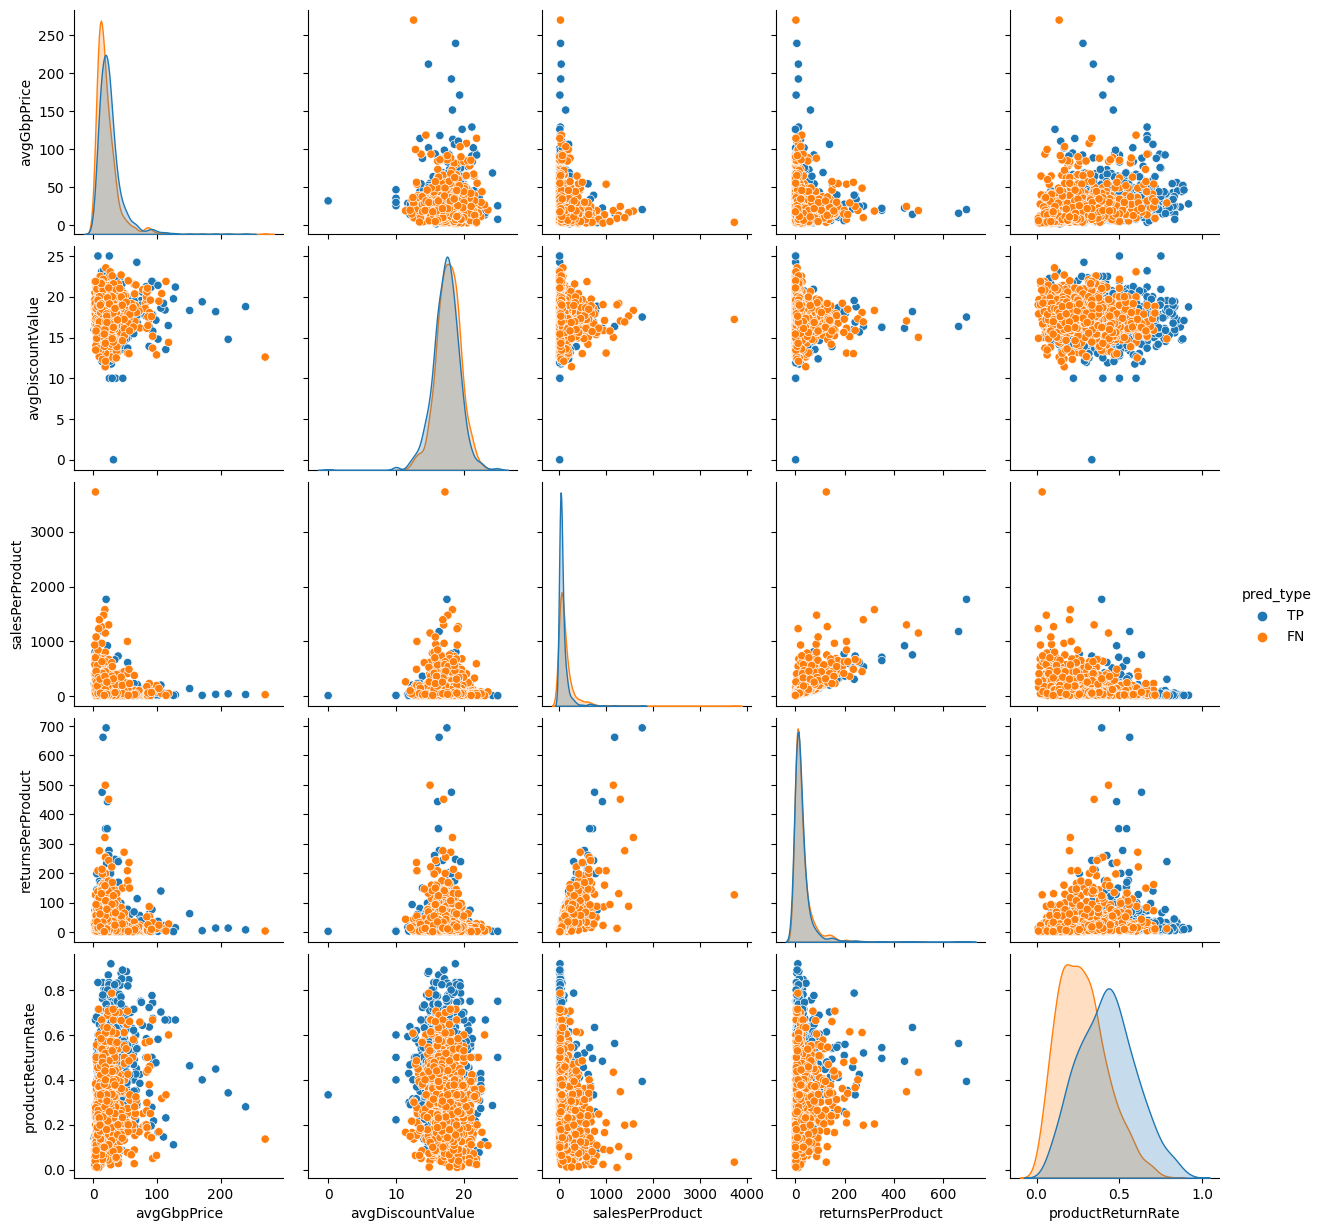

In [14]:
sns.pairplot(data=tpfn_var[["avgGbpPrice",
                        "avgDiscountValue", 
                        "salesPerProduct", 
                        "returnsPerProduct", 
                        "productReturnRate", 
                               "pred_type"]], hue="pred_type")

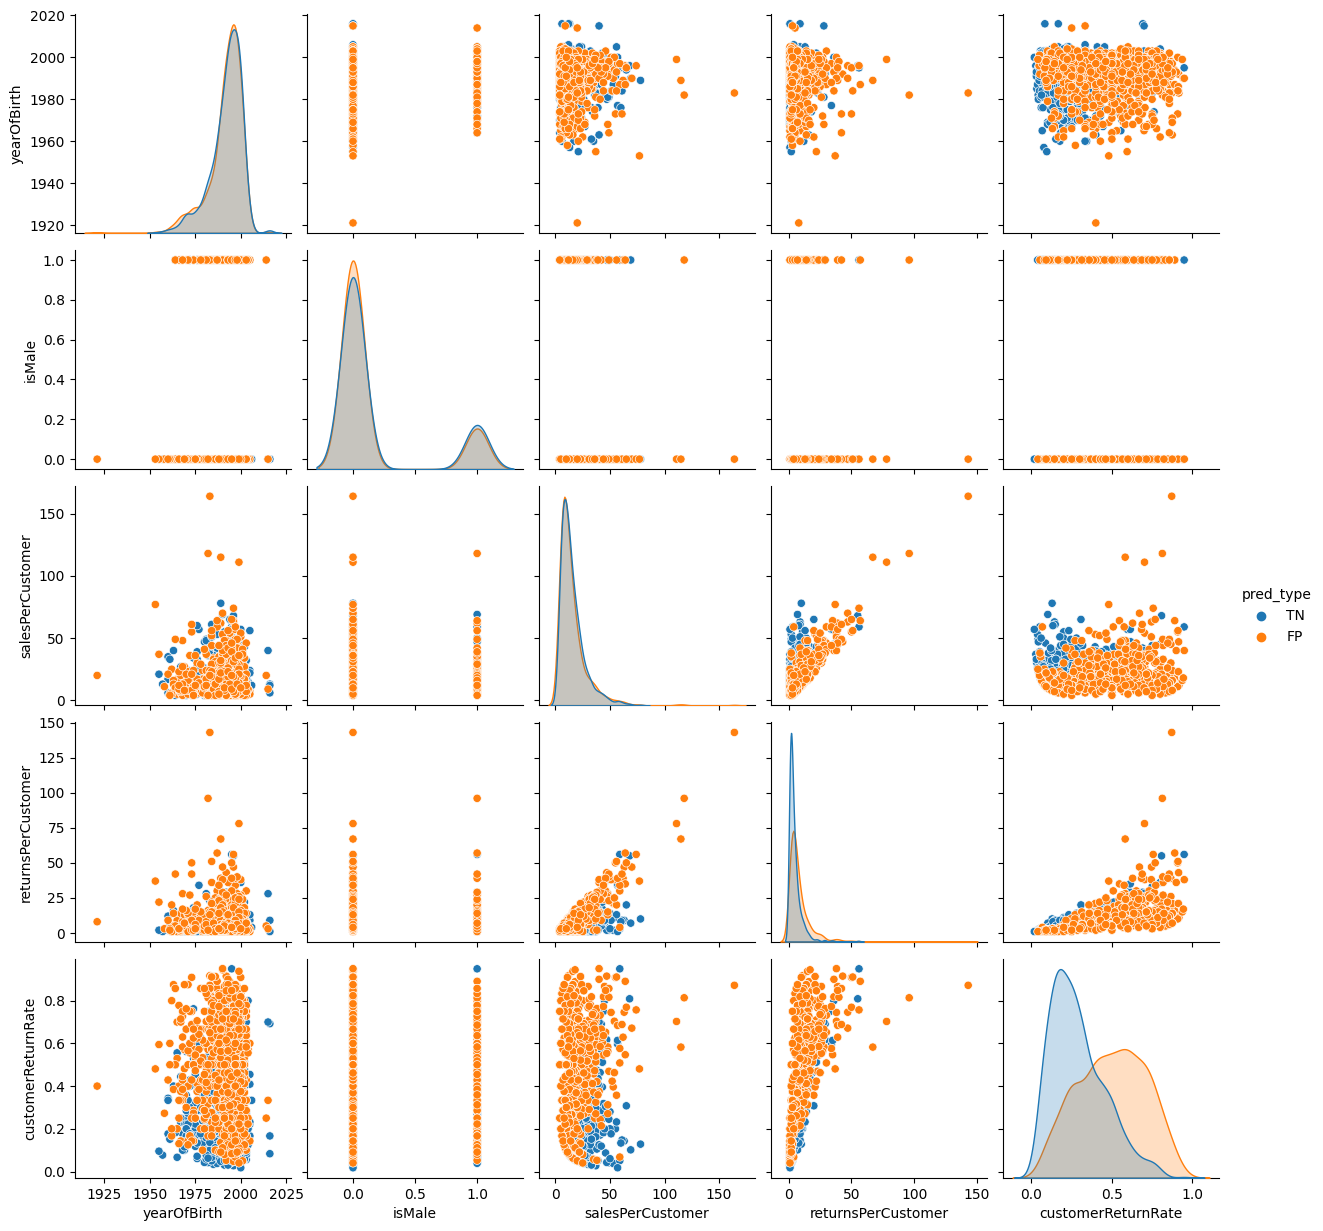

In [29]:
sns.pairplot(data=tnfp_cust[["yearOfBirth", 
                               "isMale", 
                               "salesPerCustomer", 
                               "returnsPerCustomer", 
                               "customerReturnRate", 
                               "pred_type"]], hue="pred_type")

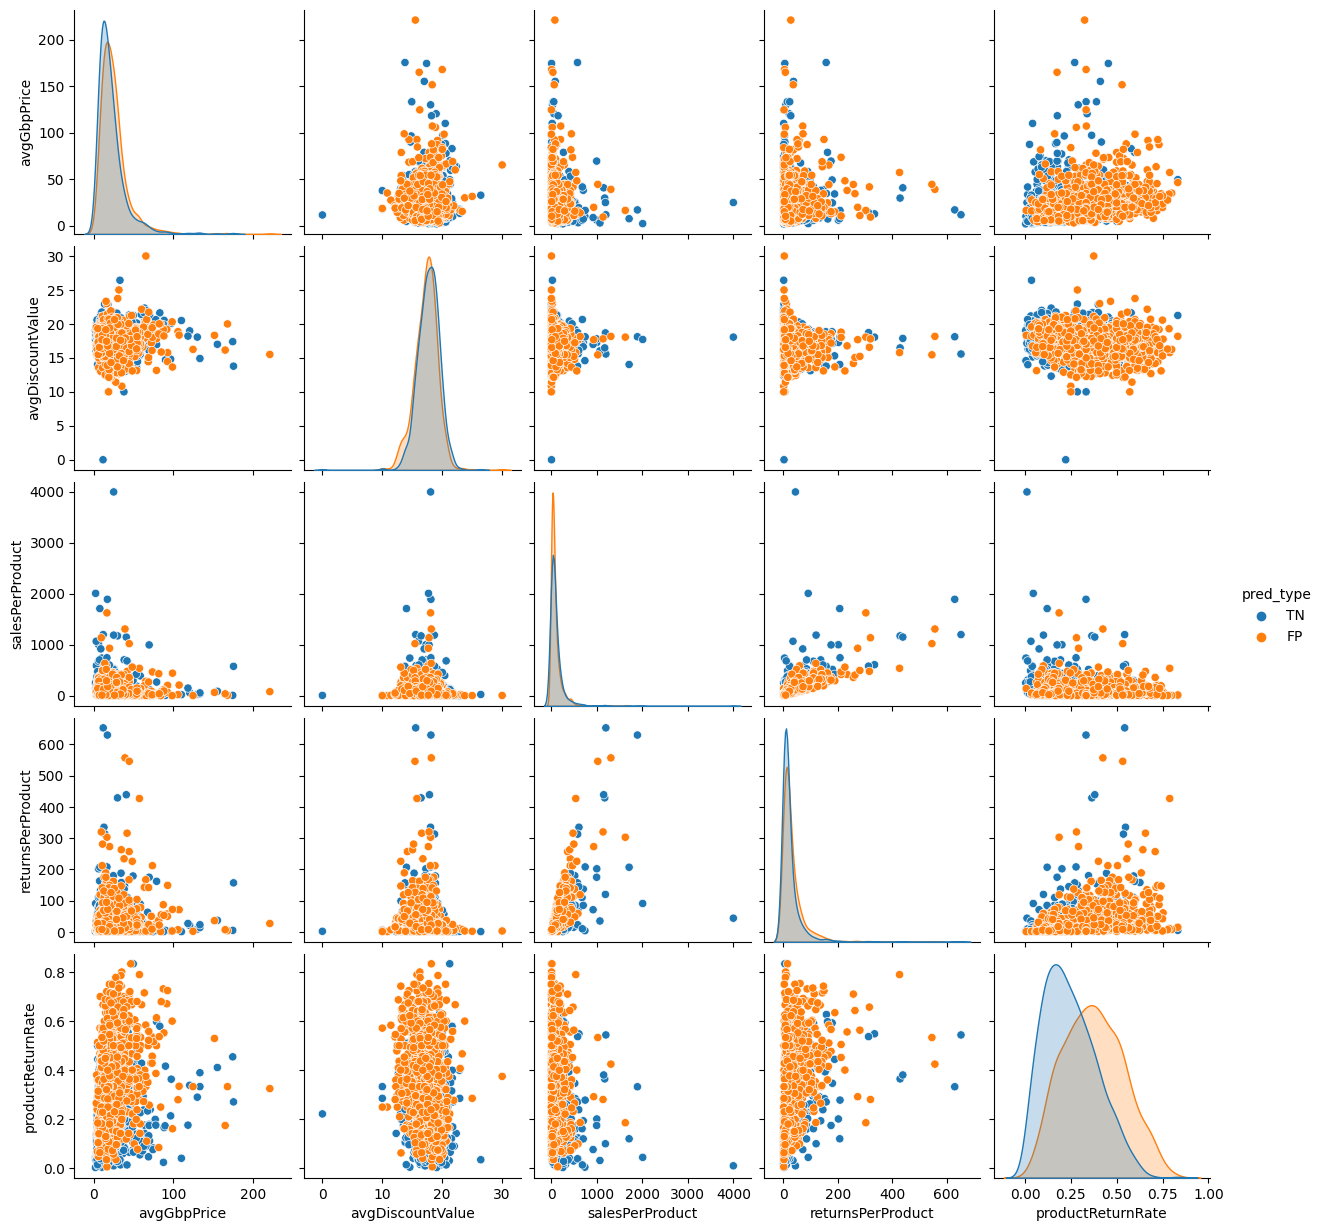

In [30]:
sns.pairplot(data=tnfp_var[["avgGbpPrice",
                        "avgDiscountValue", 
                        "salesPerProduct", 
                        "returnsPerProduct", 
                        "productReturnRate", 
                               "pred_type"]], hue="pred_type")

### Average example of TP, FP, TN and FN

Now we have this inforamtion we should try and calculate an average example of a product and customer which falls into the category of TP, FP, TN and FN.

##### Average Customer Item return interaction that is predicted as a return (TP)

In [85]:
tp_avg_features = pd.merge(pd.merge(tp[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
tp_avg_features

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth             1991.500231
isMale                     0.150045
premier                    0.274368
salesPerCustomer          20.401666
returnsPerCustomer        14.048010
                           ...     
productType_Shorts         0.011656
productType_T-shirts       0.051660
productType_Trainers       0.010656
productType_Trousers       0.064162
productType_other          0.390592
Length: 69, dtype: float64

##### Average Customer Item no return interaction that is predicted as a return (FP)

In [86]:
fp_avg_features = pd.merge(pd.merge(fp[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
fp_avg_features

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth             1991.551737
isMale                     0.177844
premier                    0.249819
salesPerCustomer          17.958367
returnsPerCustomer         9.075434
                           ...     
productType_Shorts         0.011804
productType_T-shirts       0.071125
productType_Trainers       0.013089
productType_Trousers       0.055197
productType_other          0.438183
Length: 69, dtype: float64

##### Average Customer Item no return interaction that is predicted as not a return (TN)

In [87]:
tn_avg_features = pd.merge(pd.merge(tn[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
tn_avg_features

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth             1991.575855
isMale                     0.193731
premier                    0.323749
salesPerCustomer          18.522185
returnsPerCustomer         4.976437
                           ...     
productType_Shorts         0.022351
productType_T-shirts       0.108330
productType_Trainers       0.022870
productType_Trousers       0.020159
productType_other          0.639281
Length: 69, dtype: float64

##### Average Customer Item return interaction that is predicted as not a return (FN)

In [88]:
fn_avg_features = pd.merge(pd.merge(fn[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
fn_avg_features

/Users/jamie/opt/anaconda3/envs/asos-gnn-returns/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth             1991.509793
isMale                     0.192038
premier                    0.409819
salesPerCustomer          19.475337
returnsPerCustomer         8.254529
                           ...     
productType_Shorts         0.025859
productType_T-shirts       0.107017
productType_Trainers       0.030844
productType_Trousers       0.030409
productType_other          0.547980
Length: 69, dtype: float64

## Oversmoothing Analysis

There doesn't seem to be too much separation between the features which makes sense because it is definitely not a linear problem. So now we should check for a measure of oversmoothing by looking at the mean average distance between class predictions in the embedding space.

In [116]:
from torch_geometric.loader import NeighborLoader

dataloader = NeighborLoader(
            data.data[0],
            directed=False,
            # Sample 30 neighbors for each node for 2 iterations
            num_neighbors={key: [10] * 2 for key in data.data[0].edge_types},
            # Use a batch size of 128 for sampling training nodes
            batch_size=128,
            input_nodes=("customer", data.data[0]["customer"].node_index)
        )



In [99]:
preds = model.model.forward(batch.x_dict, batch.edge_index_dict,
                            batch["customer", "purchases", "variant"].edge_index)
targets = batch["customer", "purchases", "variant"].edge_label

emb_dict = model.model.encoder(batch.x_dict, batch.edge_index_dict)

In [48]:
import numpy as np

preds_rounded = np.round(preds[:,1].detach().numpy())

In [60]:
import torch

edge_embs = [torch.concat([emb_dict["customer"][src], emb_dict["variant"][dst]]) for src, dst in batch.edge_index_dict["customer", "purchases", "variant"].T]

pred_pos_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(preds_rounded == 1)[0]])
pred_neg_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(preds_rounded == 0)[0]])

In [89]:
from scipy.spatial import distance

pos_dist = distance.pdist(pred_pos_edge_embs, metric="cosine")
neg_dist = distance.pdist(pred_neg_edge_embs, metric="cosine")

pos_neg_dist = distance.cdist(pred_pos_edge_embs, pred_neg_edge_embs, metric="cosine")


In [90]:
print("Positive Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(pos_dist):.2f} +/- {np.std(pos_dist):.2f}")
print("")
print("Negative Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(neg_dist):.2f} +/- {np.std(neg_dist):.2f}")
print("")

print("Distance between classes")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(pos_neg_dist):.2f} +/- {np.std(pos_neg_dist):.2f}")
print("")

Positive Return Example Class
Mean average distance (+/- 1 std. dev.): 0.37 +/- 0.18

Negative Return Example Class
Mean average distance (+/- 1 std. dev.): 0.50 +/- 0.19

Distance between classes
Mean average distance (+/- 1 std. dev.): 0.54 +/- 0.21



## Phase 1 Results code

In [3]:
full_test_args = {
                    "args": {
                        "load_path": "../",
                        "reduced": False,
                        "include_product_nodes": True,
                        "customer_transforms": {
                            "dropcol": {
                                "cols": ["shippingCountry"]
                            },
                            "removeoutliers": True,
                            "dropyob": True
                        },
                        "product_transforms": {
                            "dropcol": {
                                "cols": ["brandDesc", "productType"]
                            },
                            "removeoutliers": True
                        }
                    }
                }

full_test_data_pyg = DatasetManager("gnn-pyg", full_test_args["args"], test=True)
full_test_dataset_pyg = full_test_data_pyg.data
full_test_dataset_pyg.remove_data()


full_test_data_sk = DatasetManager("baseline-sklearn", full_test_args["args"], test=True)
full_test_dataset_sk = full_test_data_sk.data

Processing...
Done!


In [4]:
full_test_dataset_pyg[0]

HeteroData(
  product_type={
    x=[137803, 13],
    num_nodes=137803,
    node_index=[137803]
  },
  customer={
    x=[529824, 30],
    num_nodes=529824,
    node_index=[529824]
  },
  product={
    x=[409717, 30],
    num_nodes=409717,
    node_index=[409717]
  },
  (product, is_type, product_type)={ edge_index=[2, 409717] },
  (product_type, type_is, product)={ edge_index=[2, 409717] },
  (customer, purchases, product)={
    edge_index=[2, 157948],
    edge_label=[157948]
  },
  (product, purchased_by, customer)={ edge_index=[2, 157948] },
  (customer, returns, product)={ edge_index=[2, 88993] },
  (product, returned_by, customer)={ edge_index=[2, 88993] }
)

In [5]:
full_test_args_no_productType = {
                    "args": {
                        "load_path": "../",
                        "reduced": False,
                        "include_product_nodes": False,
                        "customer_transforms": {
                            "dropcol": {
                                "cols": ["shippingCountry"]
                            },
                            "removeoutliers": True,
                            "dropyob": True
                        },
                        "product_transforms": {
                            "dropcol": {
                                "cols": ["brandDesc", "productType"]
                            },
                            "removeoutliers": True
                        }
                    }
                }

full_test_data_pyg_noType = DatasetManager("gnn-pyg", full_test_args_no_productType["args"], test=True)
full_test_dataset_pyg_noType = full_test_data_pyg_noType.data
full_test_dataset_pyg_noType.remove_data()

Processing...
Done!


In [6]:
full_test_dataset_pyg_noType[0]

HeteroData(
  customer={
    x=[529824, 30],
    num_nodes=529824,
    node_index=[529824]
  },
  product={
    x=[409717, 41],
    num_nodes=409717,
    node_index=[409717]
  },
  (customer, purchases, product)={
    edge_index=[2, 157948],
    edge_label=[157948]
  },
  (product, purchased_by, customer)={ edge_index=[2, 157948] },
  (customer, returns, product)={ edge_index=[2, 88993] },
  (product, returned_by, customer)={ edge_index=[2, 88993] }
)

## Baseline Results

In [6]:
file_path_10klr = "../results/reduced_10k/baseline_lr/04132022_091855"
file_path_10krf = "../results/reduced_10k/baseline_rf/04132022_092240"
# file_path_10kxgb = "../results/reduced_10k/baseline/xgboost/04012022_144953"

test_data_10klr, model_10klr = load_experiment(file_path_10klr)
test_data_10krf, model_10krf = load_experiment(file_path_10krf)
# data_10kxgb, test_data_10kxgb, model_10kxgb = load_experiment(file_path_10kxgb)

file_path_50klr = "../results/reduced_50k/baseline_lr/04132022_092620"
file_path_50krf = "../results/reduced_50k/baseline_rf/04132022_093206"
# file_path_50kxgb = "../results/reduced_50k/baseline/xgboost/04012022_144953"

test_data_50klr, model_50klr = load_experiment(file_path_50klr)
test_data_50krf, model_50krf = load_experiment(file_path_50krf)
# data_50kxgb, test_data_50kxgb, model_50kxgb = load_experiment(file_path_50kxgb)

In [7]:
test_scores_10klr = model_10klr.test((full_test_dataset_sk.X, full_test_dataset_sk.y))
test_scores_10krf = model_10krf.test((full_test_dataset_sk.X, full_test_dataset_sk.y))

test_scores_50klr = model_50klr.test((full_test_dataset_sk.X, full_test_dataset_sk.y))
test_scores_50krf = model_50krf.test((full_test_dataset_sk.X, full_test_dataset_sk.y))

In [8]:
print(55*"-")
print("Training Set | Model    | Precision | Recall | F1-score")
print(55*"-")
print(f"Reduced 10k  | Log Reg  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
print(f"             | Rnd Fst  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
print(55*"-")
print(f"Reduced 50k  | Log Reg  | {test_scores_50klr['precision']:.2f}\t    | {test_scores_50klr['recall']:.2f}   | {test_scores_50klr['f1-score']:.2f}")
print(f"             | Rnd Fst  | {test_scores_50klr['precision']:.2f}\t    | {test_scores_50klr['recall']:.2f}   | {test_scores_50klr['f1-score']:.2f}")
print(55*"-")
# print(f"Full         | Log Reg  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
# print(f"             | Rnd Fst  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")


-------------------------------------------------------
Training Set | Model    | Precision | Recall | F1-score
-------------------------------------------------------
Reduced 10k  | Log Reg  | 0.99	    | 0.52   | 0.68
             | Rnd Fst  | 0.99	    | 0.52   | 0.68
-------------------------------------------------------
Reduced 50k  | Log Reg  | 0.99	    | 0.52   | 0.68
             | Rnd Fst  | 0.99	    | 0.52   | 0.68
-------------------------------------------------------


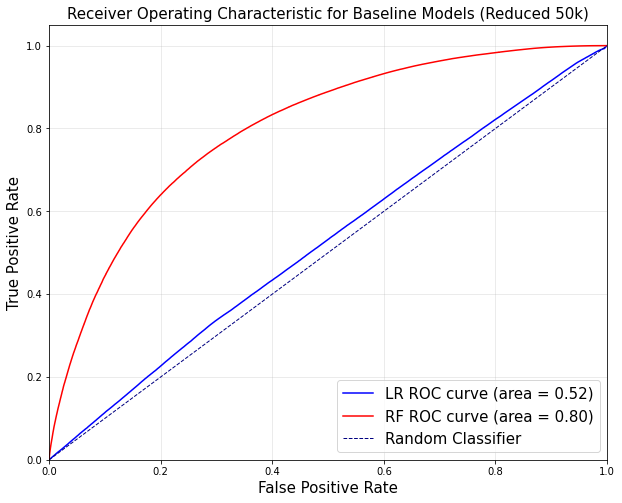

In [9]:
tpr_lr, fpr_lr, auc_lr = test_scores_50klr["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_50krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color="blue", 
         label=f"LR ROC curve (area = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for Baseline Models (Reduced 50k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/baseline_roc_curves.png")
plt.show()

## GNN Results

In [10]:
def get_GNN_score(path):
    test_data_gnn, model_gnn = load_experiment(path)
    test_scores_gnn = model_gnn.test(full_test_dataset_pyg[0])
    return test_scores_gnn

In [11]:
file_path_gnn_r10kA = "../results/reduced_10k/gnn/04132022_113016"
file_path_gnn_r10kB = "../results/reduced_10k/gnn/04132022_113205"
file_path_gnn_r10kC = "../results/reduced_10k/gnn/04132022_113452"

socres_gnn_r10kA = get_GNN_score(file_path_gnn_r10kA)
socres_gnn_r10kB = get_GNN_score(file_path_gnn_r10kB)
socres_gnn_r10kC = get_GNN_score(file_path_gnn_r10kC)


file_path_gnn_r50kA = "../results/reduced_50k/gnn/04132022_113935"
file_path_gnn_r50kB = "../results/reduced_50k/gnn/04132022_114525"
file_path_gnn_r50kC = "../results/reduced_50k/gnn/04132022_115701"

socres_gnn_r50kA = get_GNN_score(file_path_gnn_r50kA)
socres_gnn_r50kB = get_GNN_score(file_path_gnn_r50kB)
socres_gnn_r50kC = get_GNN_score(file_path_gnn_r50kC)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [12]:
print(55*"-")
print("Training Set | Model    | Precision | Recall | F1-score")
print(55*"-")
print(f"Reduced 10k  | GNN A    | {socres_gnn_r10kA['precision']:.2f}\t    | {socres_gnn_r10kA['recall']:.2f}   | {socres_gnn_r10kA['f1-score']:.2f}")
print(f"             | GNN B    | {socres_gnn_r10kB['precision']:.2f}\t    | {socres_gnn_r10kB['recall']:.2f}   | {socres_gnn_r10kB['f1-score']:.2f}")
print(f"             | GNN C    | {socres_gnn_r10kC['precision']:.2f}\t    | {socres_gnn_r10kC['recall']:.2f}   | {socres_gnn_r10kC['f1-score']:.2f}")
print(55*"-")
print(f"Reduced 50k  | GNN A    | {socres_gnn_r50kA['precision']:.2f}\t    | {socres_gnn_r50kA['recall']:.2f}   | {socres_gnn_r50kA['f1-score']:.2f}")
print(f"             | GNN B    | {socres_gnn_r50kB['precision']:.2f}\t    | {socres_gnn_r50kB['recall']:.2f}   | {socres_gnn_r50kB['f1-score']:.2f}")
print(f"             | GNN C    | {socres_gnn_r50kC['precision']:.2f}\t    | {socres_gnn_r50kC['recall']:.2f}   | {socres_gnn_r50kC['f1-score']:.2f}")
print(55*"-")


-------------------------------------------------------
Training Set | Model    | Precision | Recall | F1-score
-------------------------------------------------------
Reduced 10k  | GNN A    | 0.97	    | 0.74   | 0.84
             | GNN B    | 0.99	    | 0.79   | 0.88
             | GNN C    | 0.99	    | 0.70   | 0.82
-------------------------------------------------------
Reduced 50k  | GNN A    | 0.97	    | 0.76   | 0.85
             | GNN B    | 0.99	    | 0.79   | 0.88
             | GNN C    | 0.96	    | 0.78   | 0.86
-------------------------------------------------------


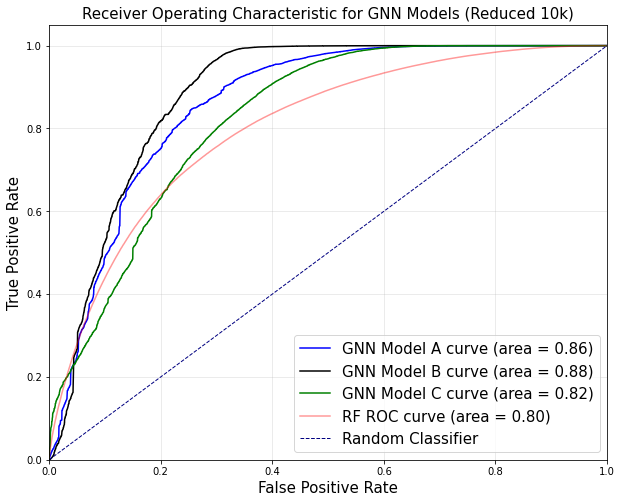

In [13]:
tpr_A, fpr_A, auc_A = socres_gnn_r10kA["roc"].values()
tpr_B, fpr_B, auc_B = socres_gnn_r10kB["roc"].values()
tpr_C, fpr_C, auc_C = socres_gnn_r10kC["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_10krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_A, tpr_A, color="blue", 
         label=f"GNN Model A curve (area = {auc_A:.2f})")
plt.plot(fpr_B, tpr_B, color="black", 
         label=f"GNN Model B curve (area = {auc_B:.2f})")
plt.plot(fpr_C, tpr_C, color="green", 
         label=f"GNN Model C curve (area = {auc_C:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})", alpha =0.4)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for GNN Models (Reduced 10k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/GNN_roc_curves_10k.png")
plt.show()

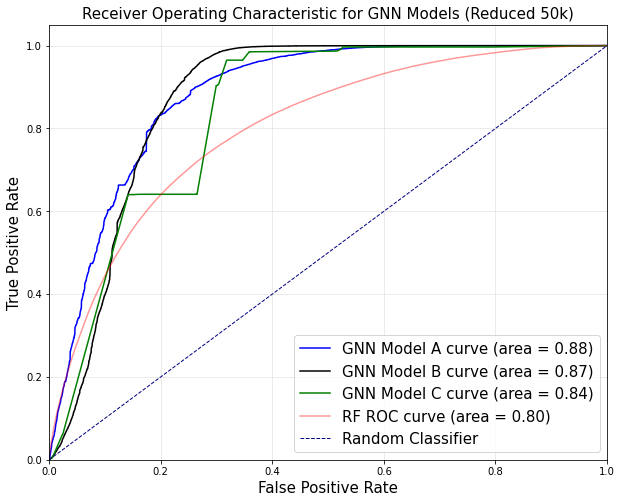

In [14]:
tpr_A, fpr_A, auc_A = socres_gnn_r50kA["roc"].values()
tpr_B, fpr_B, auc_B = socres_gnn_r50kB["roc"].values()
tpr_C, fpr_C, auc_C = socres_gnn_r50kC["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_50krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_A, tpr_A, color="blue", 
         label=f"GNN Model A curve (area = {auc_A:.2f})")
plt.plot(fpr_B, tpr_B, color="black", 
         label=f"GNN Model B curve (area = {auc_B:.2f})")
plt.plot(fpr_C, tpr_C, color="green", 
         label=f"GNN Model C curve (area = {auc_C:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})", alpha =0.4)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for GNN Models (Reduced 50k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/GNN_roc_curves_50k.png")
plt.show()

## Different Country Markets

In [15]:
def get_GNN_and_testdata(path):
    data_gnn, test_data_gnn, model_gnn = load_experiment(path)
    return model_gnn, test_data_gnn

file_path_lr_Oz = "../results/Oz_reduced_50k/baseline_lr/04132022_213915"
file_path_lr_Aus = "../results/Aus_reduced_50k/baseline_lr/04132022_212945"
file_path_lr_Den = "../results/Den_reduced_50k/baseline_lr/04132022_213400"
file_path_lr_Fr = "../results/Fr_reduced_50k/baseline_lr/04132022_213545"
file_path_lr_Ger = "../results/Ger_reduced_50k/baseline_lr/04132022_213729"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_lr_All = "../results/reduced_50k/baseline_lr/04132022_215352"

file_path_rf_Oz = "../results/Oz_reduced_50k/baseline_rf/04132022_213956"
file_path_rf_Aus = "../results/Aus_reduced_50k/baseline_rf/04132022_213305"
file_path_rf_Den = "../results/Den_reduced_50k/baseline_rf/04132022_213453"
file_path_rf_Fr = "../results/Fr_reduced_50k/baseline_rf/04132022_213640"
file_path_rf_Ger = "../results/Ger_reduced_50k/baseline_rf/04132022_213820"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_rf_All = "../results/reduced_50k/baseline_rf/04132022_215233"

lr_Oz, test_data_lrOz = get_GNN_and_testdata(file_path_lr_Oz)
lr_Aus, test_data_lrAus = get_GNN_and_testdata(file_path_lr_Aus)
lr_Den, test_data_lrDen = get_GNN_and_testdata(file_path_lr_Den)
lr_Fr, test_data_lrFr = get_GNN_and_testdata(file_path_lr_Fr)
lr_Ger, test_data_lrGer = get_GNN_and_testdata(file_path_lr_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
lr_All, test_data_lrAll = get_GNN_and_testdata(file_path_lr_All)

rf_Oz, test_data_rfOz = get_GNN_and_testdata(file_path_rf_Oz)
rf_Aus, test_data_rfAus = get_GNN_and_testdata(file_path_rf_Aus)
rf_Den, test_data_rfDen = get_GNN_and_testdata(file_path_rf_Den)
rf_Fr, test_data_rfFr = get_GNN_and_testdata(file_path_rf_Fr)
rf_Ger, test_data_rfGer = get_GNN_and_testdata(file_path_rf_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
rf_All, test_data_rfAll = get_GNN_and_testdata(file_path_rf_All)

In [21]:
lrscores_Oz_Oz = lr_Oz.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
lrscores_Aus_Aus = lr_Aus.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
lrscores_Den_Den = lr_Den.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
lrscores_Fr_Fr = lr_Fr.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
lrscores_Ger_Ger = lr_Ger.test((test_data_lrGer.data.X, test_data_lrGer.data.y))
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

lrscores_all_Oz = lr_All.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
lrscores_all_Aus = lr_All.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
lrscores_all_Den = lr_All.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
lrscores_all_Fr = lr_All.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
lrscores_all_Ger = lr_All.test((test_data_lrGer.data.X, test_data_lrGer.data.y))

rfscores_Oz_Oz = rf_Oz.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
rfscores_Aus_Aus = rf_Aus.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
rfscores_Den_Den = rf_Den.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
rfscores_Fr_Fr = rf_Fr.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
rfscores_Ger_Ger = rf_Ger.test((test_data_lrGer.data.X, test_data_lrGer.data.y))
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

rfscores_all_Oz = rf_All.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
rfscores_all_Aus = rf_All.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
rfscores_all_Den = rf_All.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
rfscores_all_Fr = rf_All.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
rfscores_all_Ger = rf_All.test((test_data_lrGer.data.X, test_data_lrGer.data.y))

In [22]:
file_path_gnn_Oz = "../results/Oz_reduced_50k/gnn/04132022_174936"
file_path_gnn_Aus = "../results/Aus_reduced_50k/gnn/04132022_170128"
file_path_gnn_Den = "../results/Den_reduced_50k/gnn/04132022_170339"
file_path_gnn_Fr = "../results/Fr_reduced_50k/gnn/04132022_170517"
file_path_gnn_Ger = "../results/Ger_reduced_50k/gnn/04132022_175101"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_gnn_All = "../results/reduced_50k/gnn/04132022_180640"

gnn_Oz, test_data_Oz = get_GNN_and_testdata(file_path_gnn_Oz)
gnn_Aus, test_data_Aus = get_GNN_and_testdata(file_path_gnn_Aus)
gnn_Den, test_data_Den = get_GNN_and_testdata(file_path_gnn_Den)
gnn_Fr, test_data_Fr = get_GNN_and_testdata(file_path_gnn_Fr)
gnn_Ger, test_data_Ger = get_GNN_and_testdata(file_path_gnn_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
gnn_All, test_data_All = get_GNN_and_testdata(file_path_gnn_All)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [23]:
scores_Oz_Oz = gnn_Oz.test(test_data_Oz.data[0])
scores_Aus_Aus = gnn_Aus.test(test_data_Aus.data[0])
scores_Den_Den = gnn_Den.test(test_data_Den.data[0])
scores_Fr_Fr = gnn_Fr.test(test_data_Fr.data[0])
scores_Ger_Ger = gnn_Ger.test(test_data_Ger.data[0])
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

scores_all_Oz = gnn_All.test(test_data_Oz.data[0])
scores_all_Aus = gnn_All.test(test_data_Aus.data[0])
scores_all_Den = gnn_All.test(test_data_Den.data[0])
scores_all_Fr = gnn_All.test(test_data_Fr.data[0])
scores_all_Ger = gnn_All.test(test_data_Ger.data[0])

scores_Oz_all = gnn_Oz.test(test_data_All.data[0])
scores_Aus_all = gnn_Aus.test(test_data_All.data[0])
scores_Den_all = gnn_Den.test(test_data_All.data[0])
scores_Fr_all = gnn_Fr.test(test_data_All.data[0])
scores_Ger_all = gnn_Ger.test(test_data_All.data[0])
scores_all_all = gnn_All.test(test_data_All.data[0])

In [24]:
print(65*"-")
print("Model         | Australia  | Austria | Denmark | France | Germany")
print(65*"-")
print(f"Log Reg       | {lrscores_Oz_Oz['f1-score']:.3f}      | {lrscores_Aus_Aus['f1-score']:.3f}   | {lrscores_Den_Den['f1-score']:.3f}   | {lrscores_Fr_Fr['f1-score']:.3f}  | {lrscores_Ger_Ger['f1-score']:.3f}")
print(f"Rnd Fst       | {rfscores_Oz_Oz['f1-score']:.3f}      | {rfscores_Aus_Aus['f1-score']:.3f}   | {rfscores_Den_Den['f1-score']:.3f}   | {rfscores_Fr_Fr['f1-score']:.3f}  | {rfscores_Ger_Ger['f1-score']:.3f}")
print(f"GNN B         | {scores_Oz_Oz['f1-score']:.3f}      | {scores_Aus_Aus['f1-score']:.3f}   | {scores_Den_Den['f1-score']:.3f}   | {scores_Fr_Fr['f1-score']:.3f}  | {scores_Ger_Ger['f1-score']:.3f}")
print(65*"-")
print(f"Log Reg (All) | {lrscores_all_Oz['f1-score']:.3f}      | {lrscores_all_Aus['f1-score']:.3f}   | {lrscores_all_Den['f1-score']:.3f}   | {lrscores_all_Fr['f1-score']:.3f}  | {lrscores_all_Ger['f1-score']:.3f}")
print(f"Rnd Fst (All) | {rfscores_all_Oz['f1-score']:.3f}      | {rfscores_all_Aus['f1-score']:.3f}   | {rfscores_all_Den['f1-score']:.3f}   | {rfscores_all_Fr['f1-score']:.3f}  | {rfscores_all_Ger['f1-score']:.3f}")
print(f"GNN B (All)   | {scores_all_Oz['f1-score']:.3f}      | {scores_all_Aus['f1-score']:.3f}   | {scores_all_Den['f1-score']:.3f}   | {scores_all_Fr['f1-score']:.3f}  | {scores_all_Ger['f1-score']:.3f}")
print(65*"-")


-----------------------------------------------------------------
Model         | Australia  | Austria | Denmark | France | Germany
-----------------------------------------------------------------
Log Reg       | 0.124      | 0.745   | 0.202   | 0.003  | 0.782
Rnd Fst       | 0.635      | 0.788   | 0.645   | 0.519  | 0.811
GNN B         | 0.920      | 0.987   | 0.991   | 0.966  | 0.925
-----------------------------------------------------------------
Log Reg (All) | 0.602      | 0.745   | 0.607   | 0.545  | 0.780
Rnd Fst (All) | 0.653      | 0.782   | 0.665   | 0.597  | 0.816
GNN B (All)   | 0.921      | 0.951   | 0.920   | 0.909  | 0.917
-----------------------------------------------------------------


In [25]:
print(45*"-")
print("GNN Trained on   | F1-score on all countries  ")
print(45*"-")
print(f"Australia        | {scores_Oz_all['f1-score']:.3f}")
print(f"Austria          | {scores_Aus_all['f1-score']:.3f}  ")
print(f"Denmark          | {scores_Den_all['f1-score']:.3f}  ")
print(f"France           | {scores_Fr_all['f1-score']:.3f}   ")
print(f"Germany          | {scores_Ger_all['f1-score']:.3f}   ")
print(45*"-")
print(f"All              | {scores_all_all['f1-score']:.3f} ")
print(45*"-")

---------------------------------------------
GNN Trained on   | F1-score on all countries  
---------------------------------------------
Australia        | 0.848
Austria          | 0.868  
Denmark          | 0.876  
France           | 0.863   
Germany          | 0.866   
---------------------------------------------
All              | 0.887 
---------------------------------------------


## German's who bought ASOS Design

In [13]:
file_path = "../results/full/gnn/04142022_095109"

gnn_Ger_ASOS, test_data_GER_ASOS = get_GNN_and_testdata(file_path)

Processing...
Done!
Processing...
Done!


In [30]:
test_data_GER_ASOS.data[0]

HeteroData(
  customer={
    x=[122858, 30],
    num_nodes=122858,
    node_index=[122858]
  },
  product={
    x=[111773, 41],
    num_nodes=111773,
    node_index=[111773]
  },
  (customer, purchases, product)={
    edge_index=[2, 14739],
    edge_label=[14739]
  },
  (product, purchased_by, customer)={ edge_index=[2, 14739] },
  (customer, returns, product)={ edge_index=[2, 10317] },
  (product, returned_by, customer)={ edge_index=[2, 10317] }
)

In [24]:
test_data_GER_ASOS.data.data["customer"]["x"][:,-10:].sum(axis=0)

tensor([     0.,      0.,      0.,      0., 122858.,      0.,      0.,      0.,
             0.,      0.])

In [25]:
test_data_GER_ASOS.data.data["product"]["x"][:,-21:-11].sum(axis=0)

tensor([     0., 111773.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.])

In [27]:
scores = gnn_Ger_ASOS.test(test_data_GER_ASOS.data[0])

In [29]:
scores["f1-score"]

0.8235153256704981

<AxesSubplot:ylabel='Frequency'>

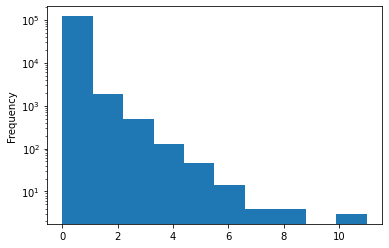

In [32]:
import torch_geometric.utils as U
import pandas as pd

node_degree = U.degree(test_data_GER_ASOS.data.data['product', 'purchased_by', 'customer'].edge_index[1])
pd.Series(node_degree.cpu()).plot.hist(bins=10, range=(0,11), log= True)

In [33]:
gnn_Ger.test(test_data_GER_ASOS.data[0])

NameError: name 'gnn_Ger' is not defined